In [3]:
from pathlib import Path

# eda_summary.md 내용
eda_summary = """
# 📊 EDA Summary

## ✅ 기본 정보
- 총 샘플 수: 1460개
- 총 컬럼 수: 81개
- 타겟 변수: `SalePrice` (연속형)
- 식별자 컬럼: `Id` (모델 학습에 불필요)

## 🧩 컬럼 타입
- 수치형(int/float): 38개
- 범주형(object): 43개

## 🚨 결측치 분석
- 총 19개 컬럼에 결측 존재
- 상위 결측 컬럼:
  - `PoolQC`: 1453개 → 수영장 없음 (MAR)
  - `MiscFeature`: 1406개 → 특이 시설 없음 (MAR)
  - `Alley`: 1369개 → 골목 없음 (MAR)
  - `Fence`: 1179개 → 울타리 없음 (MAR)
  - `FireplaceQu`: 690개 → 벽난로 없음 (MAR)
- `Electrical`: 1개 → 입력 누락 (MCAR)

## 📌 결측 유형 분류
- 대부분 **MAR (Missing At Random)** → 다른 변수로부터 예측 가능
- `Electrical`: **MCAR** → 최빈값 대체
- `LotFrontage`: 지역(Neighborhood) 기반 평균 대체 고려

## 🔎 향후 계획
- `SalePrice` 분포 시각화 및 로그 변환 여부 확인
- 수치형 변수 상관관계 분석
- 범주형 변수별 평균 가격 시각화
"""

# eda.ipynb 생성 (간단한 코드 베이스 EDA 노트북)
import nbformat as nbf

nb = nbf.v4.new_notebook()
nb.cells = [
    nbf.v4.new_markdown_cell("# 📊 Initial EDA\nEDA for House Prices Dataset"),
    nbf.v4.new_code_cell("import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns"),
    nbf.v4.new_code_cell("df = pd.read_csv('data/train.csv')\ndf.shape, df.dtypes.value_counts()"),
    nbf.v4.new_code_cell("df.isnull().sum().sort_values(ascending=False).head(10)"),
    nbf.v4.new_markdown_cell("### 🔍 결측치 상위 항목 및 분류\n- 대부분 MAR로 판단\n- `Electrical`: MCAR\n- `LotFrontage`: 지역 기반 보간 고려"),
    nbf.v4.new_code_cell("df.select_dtypes(include='object').nunique().sort_values(ascending=False).head()")
]

# 저장 경로
Path("reports").mkdir(parents=True, exist_ok=True)
Path("notebooks").mkdir(parents=True, exist_ok=True)

# 파일 저장
with open("reports/eda_summary.md", "w", encoding="utf-8") as f:
    f.write(eda_summary)

with open("notebooks/eda.ipynb", "w", encoding="utf-8") as f:
    nbf.write(nb, f)

In [6]:
import pandas as pd

df = pd.read_csv('/home/dev/data-analysis/data/houseprice/raw/train.csv')

# 결측치가 있는 컬럼 목록 추출
missing_cols = df.columns[df.isnull().any()]

# 결측 변수와 관련 가능성이 있는 변수 확인 (상관관계, 조건부 결측 등)
# 상관관계 분석용으로 수치형 변수만 대상으로 함
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 결측 컬럼 중 object형 제외 후 corr() 사용 가능한 것에 대해 살펴보기
correlation_insights = {}
for col in missing_cols:
    if df[col].dtype in ['float64', 'int64']:
        related = df[numerical_cols].corrwith(df[col])
        strong = related[related.abs() > 0.3].drop(col, errors='ignore')
        if not strong.empty:
            correlation_insights[col] = strong.sort_values(ascending=False)

# 결과를 마크다운 형식으로 정리
eda_missing_detail = "## 🧩 전체 결측 컬럼 분석\n\n"
for col in missing_cols:
    count = df[col].isnull().sum()
    if col == "Electrical":
        reason = "- `Electrical`: **MCAR** - 단 하나의 결측으로, 입력 누락 가능성이 큼.\n"
    elif col == "LotFrontage":
        reason = "- `LotFrontage`: **MAR** - `Neighborhood`와 상관이 있으며, 지역 평균을 기반으로 보간 가능.\n"
    elif col.startswith("Garage"):
        reason = f"- `{col}`: **MAR** - `GarageCars`가 0인 경우에 결측 발생 → 차고가 없는 경우로 해석 가능.\n"
    elif col.startswith("Bsmt"):
        reason = f"- `{col}`: **MAR** - `TotalBsmtSF`가 0인 경우 결측 → 지하실 없음.\n"
    elif col in ["PoolQC", "Fence", "FireplaceQu", "Alley", "MiscFeature"]:
        reason = f"- `{col}`: **MAR** - 해당 설비가 없는 경우 결측 발생.\n"
    elif col in ["MasVnrType", "MasVnrArea"]:
        reason = "- `MasVnrType`, `MasVnrArea`: **MAR** - 벽돌 마감이 없는 경우 결측.\n"
    else:
        reason = f"- `{col}`: 결측 원인 분석 필요 (추정 불가).\n"

    if col in correlation_insights:
        reason += f"  - 관련 변수 예시: {', '.join(correlation_insights[col].index[:3])}\n"

    eda_missing_detail += f"### 🔹 {col} ({count}개 결측)\n{reason}\n"

# Append to existing summary
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(eda_missing_detail)

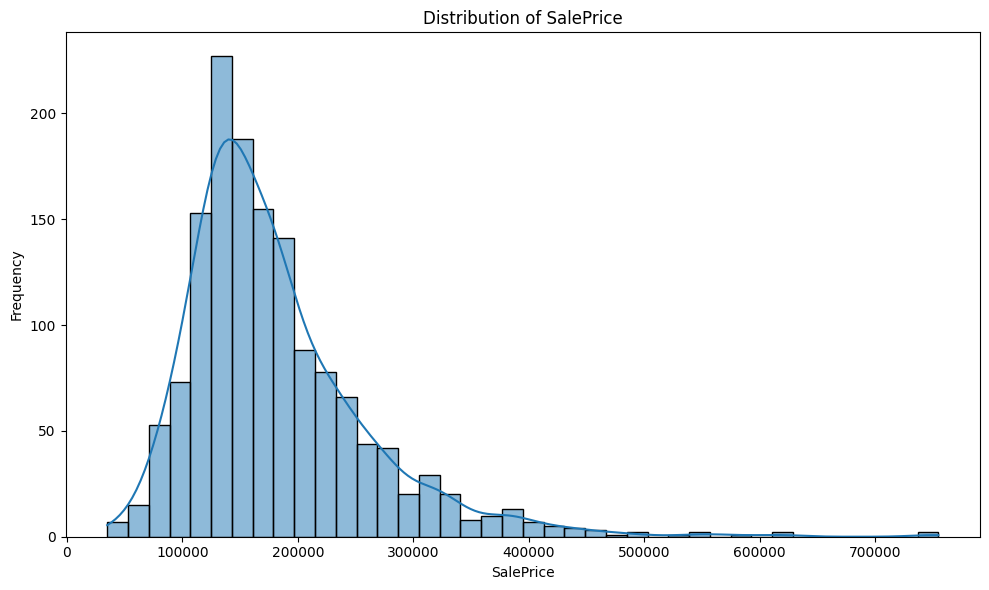

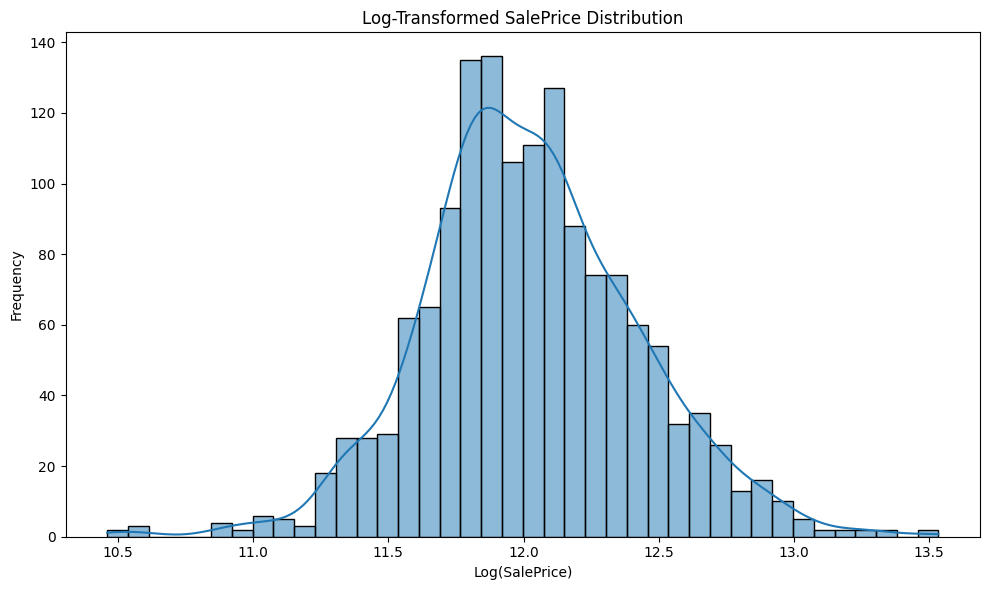

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Path("figures").mkdir(parents=True, exist_ok=True)

# Plot SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, bins=40)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures/saleprice_distribution.png")

# SalePrice skewness and kurtosis
saleprice_skew = df['SalePrice'].skew()
saleprice_kurt = df['SalePrice'].kurt()

# 로그 변환 분포
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(df['SalePrice']), kde=True, bins=40)
plt.title('Log-Transformed SalePrice Distribution')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("figures/saleprice_log_distribution.png")

# 마크다운 요약
saleprice_summary_md = f"""
## 🎯 SalePrice 분포 분석

### 원본 분포
- `SalePrice`는 오른쪽으로 긴 꼬리를 가진 비대칭 분포 (양의 왜도)
- **Skewness (왜도)**: {saleprice_skew:.2f}
- **Kurtosis (첨도)**: {saleprice_kurt:.2f}
- 이상치 및 고가 주택이 존재함

![SalePrice 분포](../figures/saleprice_distribution.png)

### 로그 변환
- `np.log1p(SalePrice)`로 로그 변환 시 정규분포에 가까워짐
- 모델링 전 로그 변환 고려할 가치 있음

![SalePrice 로그 변환 분포](../figures/saleprice_log_distribution.png)
"""

# Markdown 파일에 결과 추가
with open("reports/eda_summary.md", "a", encoding="utf-8") as f:
    f.write(saleprice_summary_md)
